In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in custom data
with open('/kaggle/input/saved-predictions/mature_matrices_dict.pkl', 'rb') as file:
    mature_matrices_dict = pickle.load(file)
run_type_preds = pd.read_csv("/kaggle/input/saved-predictions/run_type_preds.csv")
pass_quad_preds = pd.read_csv("/kaggle/input/saved-predictions/pass_quadrant_preds.csv")
run_pass_preds = pd.read_csv('/kaggle/input/saved-predictions/run_pass_preds.csv')
print(len(run_pass_preds),len(run_type_preds),len(pass_quad_preds))
# Read In BDB csvs
folder = '/kaggle/input/nfl-big-data-bowl-2025/'
games = pd.read_csv(folder + "games.csv")
plays = pd.read_csv(folder + "plays.csv")
players = pd.read_csv(folder + "players.csv")
player_play = pd.read_csv(folder+"player_play.csv")

15874 15874 15874


In [3]:
games['gameDate'].value_counts()

gameDate
10/9/2022     14
9/25/2022     14
10/2/2022     14
9/11/2022     14
9/18/2022     13
10/30/2022    13
10/16/2022    12
10/23/2022    12
11/6/2022     11
9/19/2022      2
11/3/2022      1
10/31/2022     1
10/27/2022     1
10/24/2022     1
10/20/2022     1
10/17/2022     1
9/8/2022       1
10/13/2022     1
10/10/2022     1
10/6/2022      1
10/3/2022      1
9/29/2022      1
9/26/2022      1
9/22/2022      1
9/15/2022      1
9/12/2022      1
11/7/2022      1
Name: count, dtype: int64

In [4]:
pass_quad_preds.head()
cols = np.array([['deep_numbers_left','deep_num_to_hash_left','deep_hashes','deep_num_to_hash_right','deep_numbers_right'],
             ['middle_numbers_left','middle_num_to_hash_left','middle_hashes','middle_num_to_hash_right','middle_numbers_right'],
             ['short_numbers_left','short_num_to_hash_left','short_hashes','short_num_to_hash_right','short_numbers_right']]).flatten().tolist()
pred_cols = [cols + '_pred' for cols in cols]
pass_quad_preds.iloc[0][pred_cols].values

array([6.76858821e-04, 1.60013282e-04, 8.52420286e-04, 1.36619623e-04,
       6.34956814e-04, 7.02925958e-03, 5.91014884e-03, 6.06821850e-03,
       4.97806165e-03, 5.40285651e-03, 1.41679570e-01, 3.26580912e-01,
       1.64847448e-01, 1.99067086e-01, 1.35975659e-01])

In [5]:
run_pass_grouped = run_pass_preds.groupby(['gameId','playId'])
pass_quad_grouped = pass_quad_preds.groupby(['gameIds','playIds'])
run_type_grouped = run_type_preds.groupby(['gameIds','playIds'])
plays_grouped = plays.groupby(['gameId','playId'])

gameIds = []
playIds = []
type_probs = []
sub_type_probs = []
type = []
teams = []
epas = []
downs = []
quarters = []
for key,run_pass in run_pass_grouped:
    play = plays_grouped.get_group(key).iloc[0]

    if play.isDropback:
        # Pass
        type_prob = run_pass['pass'].values[0] # get the assigned probability for pass
        try:
            mature_matrix = mature_matrices_dict[key].flatten() # get the true pass quad matrix
        except:
            continue
        pass_quad = pass_quad_grouped.get_group(key).iloc[0][pred_cols].values # get the predicted matrix
        #pass_quad_probs = pass_quad * mature_matrix # multiply them?
        #sub_type_prob = np.prod(np.where(pass_quad_probs == 0, 1, pass_quad_probs)) # fill the 0s with 1s, multiply the probabilities for each cell?
        #sub_type_prob = np.mean(pass_quad_probs) # Add all the cells?
        num_eligible_receivers = int(np.sum(mature_matrix))
        top_indices = np.argsort(pass_quad.flatten())[-num_eligible_receivers:][::-1]
        sub_type_prob = np.mean(mature_matrix.flatten()[top_indices])
        

        type.append('pass')
    else:
        # Run
        type_prob = run_pass['run'].values[0]
        
        run_concept = play['pff_runConceptPrimary']
        try:
            sub_type_prob = run_type_grouped.get_group(key).iloc[0][run_concept]
        except:
            continue
        type.append('run')
    
    
    gameIds.append(key[0])
    playIds.append(key[1])
    type_probs.append(type_prob)
    sub_type_probs.append(sub_type_prob)
    teams.append(play['possessionTeam'])
    epas.append(play['expectedPointsAdded'])
    downs.append(play['down'])
    quarters.append(play['quarter'])

In [6]:
final_data = pd.DataFrame({
    'gameId':gameIds,
    'playId':playIds,
    'type_prob':type_probs,
    'sub_type_prob':sub_type_probs,
    'type':type,
    'team':teams,
    'epa':epas,
    'down':downs,
    'quarter':quarters
})
final_data['combined_prob'] =  final_data['type_prob'] * final_data['sub_type_prob']
final_data['combined_prob'] = final_data['combined_prob'].apply(lambda x: np.min([1,x]))
final_data.head()

,gameId,playId,type_prob,sub_type_prob,type,team,epa,down,quarter,combined_prob
0,2022090800,56,0.406476,1.000000,pass,BUF,0.004420,1,1,0.406476
1,2022090800,101,0.650255,0.417573,run,BUF,0.562363,1,1,0.271529
2,2022090800,122,0.854745,0.750000,pass,BUF,0.399209,2,1,0.641059
3,2022090800,167,0.936103,1.000000,pass,BUF,1.373441,2,1,0.936103
4,2022090800,191,0.547474,0.062603,run,BUF,-0.413325,1,1,0.034273


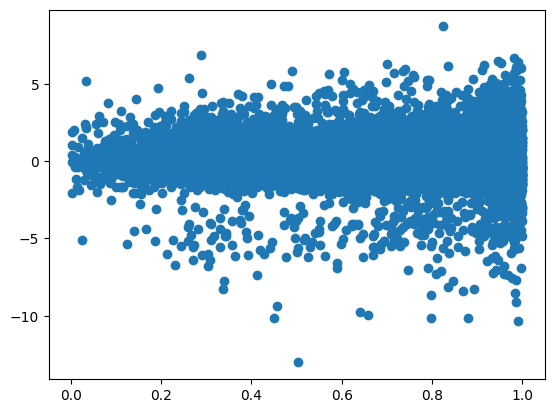

In [7]:
plt.scatter(final_data['type_prob'],final_data['epa'])

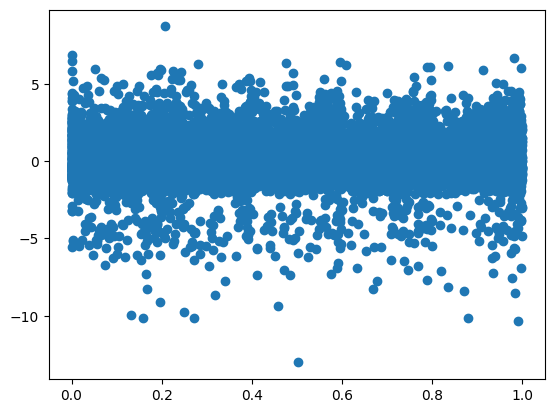

In [8]:
plt.scatter(final_data['combined_prob'],final_data['epa'])

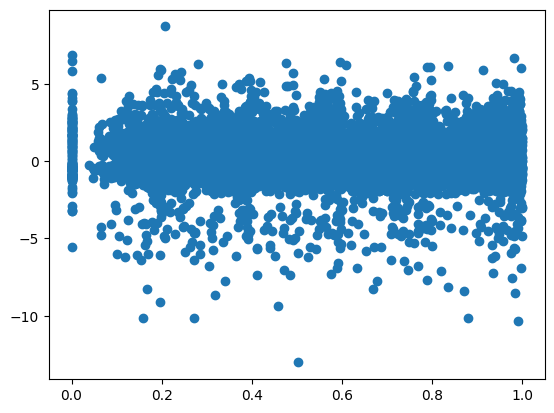

In [9]:
plt.scatter(final_data[final_data['type'] == 'pass']['combined_prob'],
            final_data[final_data['type'] == 'pass']['epa'])

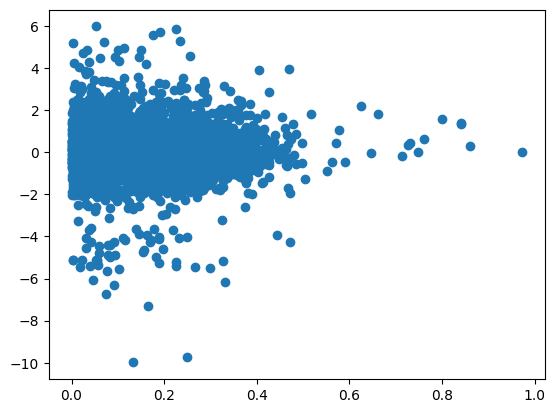

In [10]:
plt.scatter(final_data[final_data['type'] == 'run']['combined_prob'],
            final_data[final_data['type'] == 'run']['epa'])

In [11]:
final_data.groupby('team')['combined_prob'].mean().sort_values()

team
ATL    0.293739
CHI    0.296158
TEN    0.326758
NE     0.328389
BAL    0.340701
NYG    0.341488
CLE    0.356300
PHI    0.358558
SEA    0.368239
DAL    0.373134
JAX    0.384334
HOU    0.385114
DEN    0.387577
CAR    0.391349
NYJ    0.394396
BUF    0.397449
LV     0.399792
DET    0.399958
SF     0.406269
WAS    0.407780
NO     0.410385
PIT    0.410471
GB     0.412443
LAC    0.424812
MIN    0.425364
MIA    0.428880
LA     0.435868
CIN    0.440567
IND    0.442284
ARI    0.465436
KC     0.468945
TB     0.492406
Name: combined_prob, dtype: float64

In [12]:
final_data[final_data['type'] == 'pass'].groupby('team')['combined_prob'].mean().sort_values()

team
ATL    0.427686
NE     0.495909
SEA    0.505346
NYG    0.511334
CHI    0.517942
BUF    0.520700
TEN    0.524003
BAL    0.537372
DEN    0.546663
PHI    0.547997
HOU    0.552402
CLE    0.554337
NYJ    0.554361
LAC    0.559374
PIT    0.567792
LV     0.571683
MIN    0.572370
NO     0.576783
CAR    0.578807
MIA    0.579235
DAL    0.581669
WAS    0.584566
JAX    0.589737
CIN    0.597437
DET    0.597917
LA     0.600899
GB     0.603081
SF     0.611106
IND    0.618113
KC     0.635092
TB     0.654515
ARI    0.660917
Name: combined_prob, dtype: float64

In [13]:
final_data[final_data['type'] == 'run'].groupby('team')['combined_prob'].mean().sort_values()

team
LV     0.092371
ARI    0.116067
KC     0.116976
JAX    0.119716
TB     0.124695
BAL    0.126625
GB     0.130631
DET    0.131887
NE     0.133704
IND    0.137574
WAS    0.139135
LA     0.139243
PIT    0.140075
NYJ    0.140773
DAL    0.140856
CAR    0.141063
HOU    0.142244
CHI    0.142284
LAC    0.142495
MIA    0.155428
BUF    0.156082
SF     0.156856
CLE    0.159914
DEN    0.160685
NO     0.162031
NYG    0.162977
PHI    0.166606
MIN    0.170728
CIN    0.170919
SEA    0.178032
TEN    0.179738
ATL    0.196142
Name: combined_prob, dtype: float64

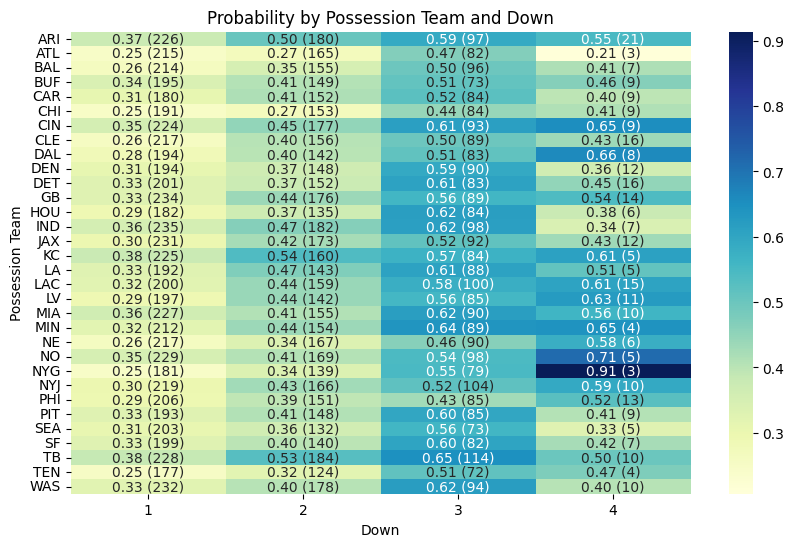

In [14]:
# Compute mean and count values
grouped = final_data.groupby(['team', 'down'])['combined_prob']
means = grouped.mean().unstack()
counts = grouped.count().unstack()

# Create a DataFrame for custom annotations with dtype=object
annot = means.astype(str).copy()
for i in range(means.shape[0]):
    for j in range(means.shape[1]):
        if not np.isnan(means.iloc[i, j]):  # Handle NaN values
            annot.iloc[i, j] = f"{means.iloc[i, j]:.2f} ({counts.iloc[i, j]})"
        else:
            annot.iloc[i, j] = ""  # Leave empty for NaN values

# Plot the heatmap with custom annotations
plt.figure(figsize=(10, 6))
sns.heatmap(means, annot=annot, fmt="", cmap="YlGnBu", cbar=True)
plt.title("Probability by Possession Team and Down")
plt.xlabel("Down")
plt.ylabel("Possession Team")
plt.show()

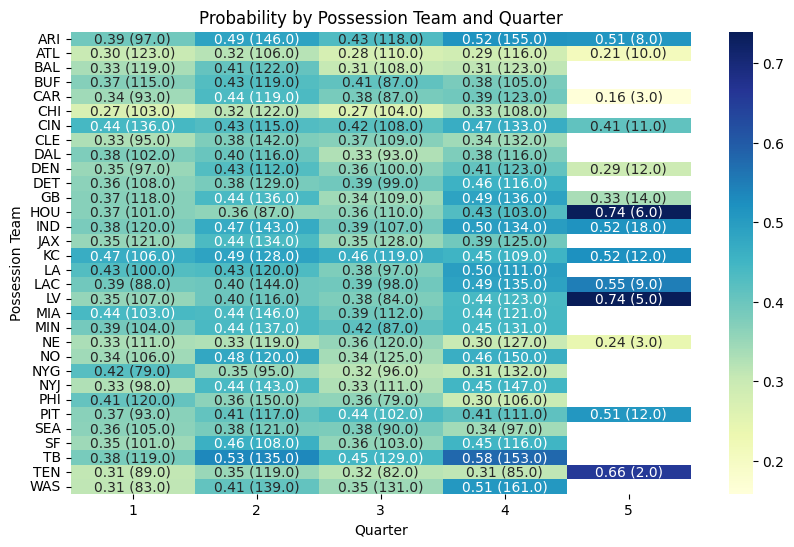

In [15]:
# Compute mean and count values
grouped = final_data.groupby(['team', 'quarter'])['combined_prob']
means = grouped.mean().unstack()
counts = grouped.count().unstack()

# Create a DataFrame for custom annotations with dtype=object
annot = means.astype(str).copy()
for i in range(means.shape[0]):
    for j in range(means.shape[1]):
        if not np.isnan(means.iloc[i, j]):  # Handle NaN values
            annot.iloc[i, j] = f"{means.iloc[i, j]:.2f} ({counts.iloc[i, j]})"
        else:
            annot.iloc[i, j] = ""  # Leave empty for NaN values

# Plot the heatmap with custom annotations
plt.figure(figsize=(10, 6))
sns.heatmap(means, annot=annot, fmt="", cmap="YlGnBu", cbar=True)
plt.title("Probability by Possession Team and Quarter")
plt.xlabel("Quarter")
plt.ylabel("Possession Team")
plt.show()

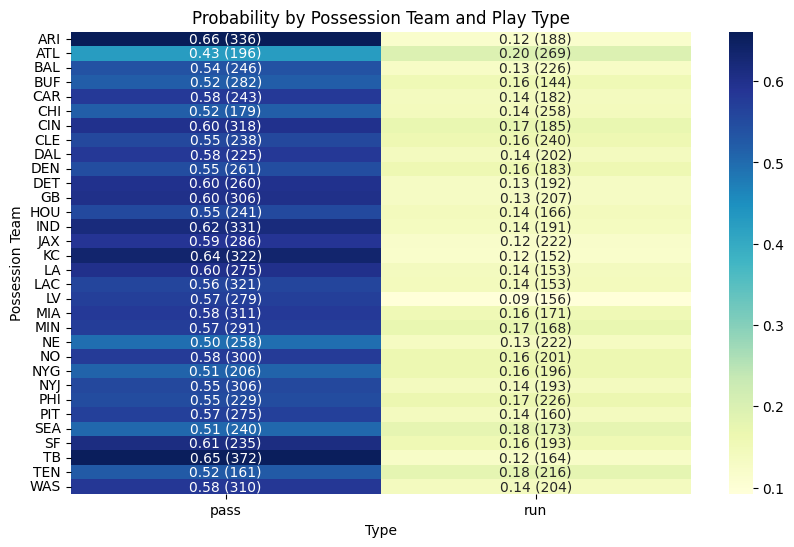

In [16]:
# Compute mean and count values
grouped = final_data.groupby(['team', 'type'])['combined_prob']
means = grouped.mean().unstack()
counts = grouped.count().unstack()

# Create a DataFrame for custom annotations with dtype=object
annot = means.astype(str).copy()
for i in range(means.shape[0]):
    for j in range(means.shape[1]):
        if not np.isnan(means.iloc[i, j]):  # Handle NaN values
            annot.iloc[i, j] = f"{means.iloc[i, j]:.2f} ({counts.iloc[i, j]})"
        else:
            annot.iloc[i, j] = ""  # Leave empty for NaN values

# Plot the heatmap with custom annotations
plt.figure(figsize=(10, 6))
sns.heatmap(means, annot=annot, fmt="", cmap="YlGnBu", cbar=True)
plt.title("Probability by Possession Team and Play Type")
plt.xlabel("Type")
plt.ylabel("Possession Team")
plt.show()

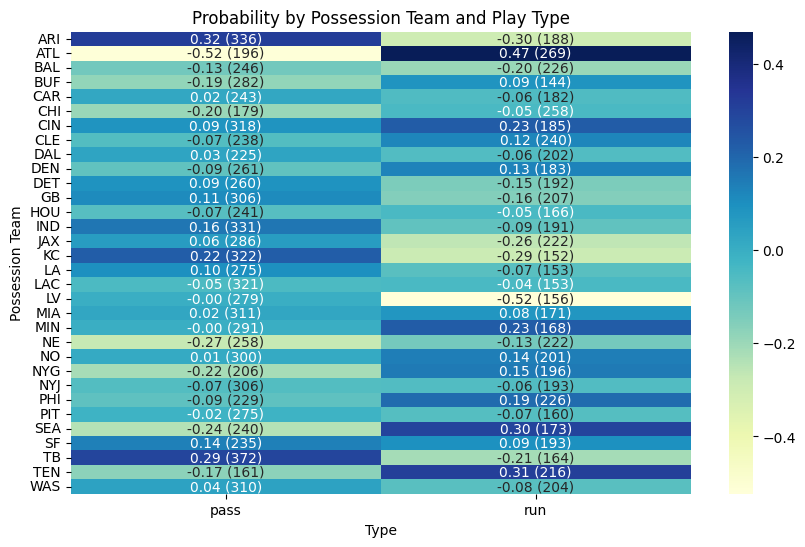

In [17]:
final_data_st = final_data.copy()
final_data_st['combined_prob'] = final_data.groupby('type')['combined_prob'].transform(
    lambda x: (x - x.mean()) / x.std()
)
# Compute mean and count values
grouped = final_data_st.groupby(['team', 'type'])['combined_prob']
means = grouped.mean().unstack()
counts = grouped.count().unstack()

# Create a DataFrame for custom annotations with dtype=object
annot = means.astype(str).copy()
for i in range(means.shape[0]):
    for j in range(means.shape[1]):
        if not np.isnan(means.iloc[i, j]):  # Handle NaN values
            annot.iloc[i, j] = f"{means.iloc[i, j]:.2f} ({counts.iloc[i, j]})"
        else:
            annot.iloc[i, j] = ""  # Leave empty for NaN values

# Plot the heatmap with custom annotations
plt.figure(figsize=(10, 6))
sns.heatmap(means, annot=annot, fmt="", cmap="YlGnBu", cbar=True)
plt.title("Probability by Possession Team and Play Type")
plt.xlabel("Type")
plt.ylabel("Possession Team")
plt.show()

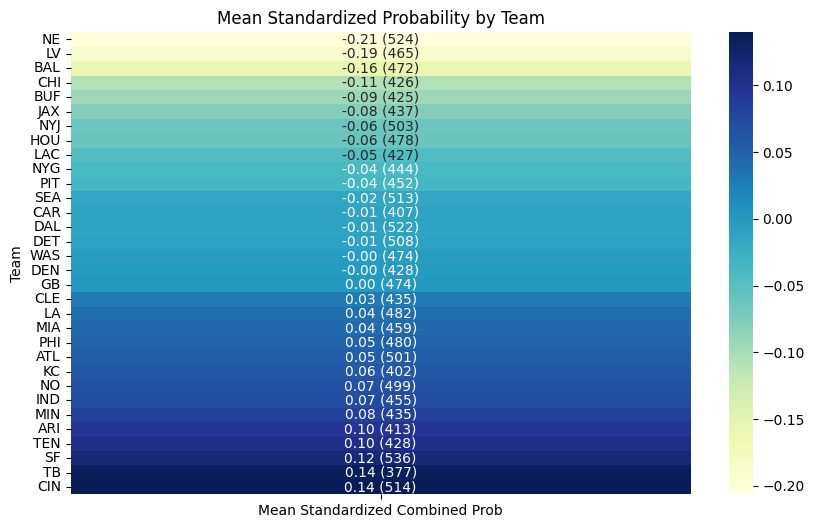

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_data is already defined
final_data_st = final_data.copy()

# Standardize 'combined_prob' within each type
final_data_st['standardized_combined_prob'] = final_data.groupby('type')['combined_prob'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Compute the overall mean by team
means = final_data_st.groupby('team')['standardized_combined_prob'].mean().sort_values()

# Count values for each team
counts = final_data_st.groupby('team')['standardized_combined_prob'].count()

# Create custom annotations
annot = pd.Series("", index=means.index, dtype=object)
for i in range(len(means)):
    if not np.isnan(means.iloc[i]):  # Handle NaN values
        annot.iloc[i] = f"{means.iloc[i]:.2f} ({counts.iloc[i]})"

# Convert means to a DataFrame for heatmap plotting
means_df = means.to_frame(name="Mean Standardized Combined Prob")

# Plot the heatmap with custom annotations
plt.figure(figsize=(10, 6))
sns.heatmap(means_df, annot=annot.values.reshape(-1, 1), fmt="", cmap="YlGnBu", cbar=True)
plt.title("Mean Standardized Probability by Team")
plt.xlabel("")
plt.ylabel("Team")
plt.show()


In [19]:
#final_data_st.head()
final_data_st.to_csv('processed_data')